<a href="https://colab.research.google.com/github/fadi-8/Disaster-Tweets/blob/main/Disaster%20Tweets%20Classification%20(ML).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h1><b><u>Disaster Tweets Classification</u></b></h1>

Disaster Tweet Classification is a competition from kaggle. I already have a notebook that preprocessed the data. In this notebook I will use the preprocessed data to make predictions using a BERT model.

BERT is a neural network classifier based on attention. It can be used for a lot of tasks, like sentence prediction, named entity recognition,...; among the tasks BERT can be used for is sentiment analysis. Sentiment analysis,normally, predicts the sentiment (positive or negative, for example) of the input text. Similarly, the disaster tweet task can be formulated where 1 means a disaster and 0 means a non-disaster tweet. Note, the BERT model is used in sentiment analysis by adding an ouput layer after BERT (or another neural network that contains an output).

Tasks that have to deal with text are usually variable length. On the other hand, many machine learning models expect a fixed length input. Thus, We can use the BERT model to map the input text to a fixed length space. Afterwards, the fixed length output can be feeded to any machine learning model.

The data can be found <a href=https://www.kaggle.com/c/nlp-getting-started/data>Here<a/>

<h4><b>1-Imports and BERT Model</b></h4>

In [1]:
!pip install tensorflow-text

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler
from tensorflow.keras.utils import plot_model
import tensorflow_hub as hub
import tensorflow_text
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold,StratifiedKFold,train_test_split
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate,GridSearchCV
from sklearn.base import clone
import pandas as pd
import os
from sys import getsizeof
import shutil

In [3]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [4]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [6]:
n_splits=5
random_state=27

To attain an useful model, a lot of training time is needed. A method to decrease the time and get even better results is by transfer learning. Transfer learning is the concept of using a trained model (with good performance) on a specific task and use its knowledge (learned weights) in another task. In this way, instead of starting with a random guess of the parameters that are unrelated to the task, with start with parameters containing information somehow related to our own task.

Tensorflow hub is a platform used to get trained models that are ready to use. The BERT model used is from tensorflow hub. Go to tensorfow hub, search for the model you need, check the guidelines.

Tensorflow hub is used below to get the BERT model.

In [ ]:
#text_input = tf.keras.layers.Input(shape=(), dtype=tf.string)

preprocessor = hub.KerasLayer(
    # "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
    "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

#encoder_inputs = preprocessor(text_input)

encoder = hub.KerasLayer(
    # "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/4",
    "https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/2",
    trainable=True)

#outputs = encoder(encoder_inputs)
#pooled_output = outputs["pooled_output"]      # [batch_size, 768].
#sequence_output = outputs["sequence_output"]  # [batch_size, seq_length, 768].

Create a BERT model


In [ ]:
text_inputs=keras.layers.Input(shape=(),dtype=tf.string)
preprocessed_text=preprocessor(text_inputs)
outputs=encoder(preprocessed_text)

BERT_model=keras.Model(text_inputs,outputs['pooled_output'],name='BERT_Model')

<h4><b>2-Helper Functions</b></h4>

The functions are used in the proceeding parts to fine-tune and train the models.

In [ ]:
def fine_tune_model(rate=0.2):
  #fine-tuning model used
  #rate=0.2

  text_inputs=keras.layers.Input(shape=(),dtype=tf.string,name='Text_Input')
  keyword_inputs=keras.layers.Input(shape=(1,),name='Keyword_Stats')

  # preprocessed_text=preprocessor(text_inputs)
  # outputs=encoder(preprocessed_text)

  BERT_output=BERT_model(text_inputs)

  #x=keras.layers.Dropout(rate=rate,name='Dropout_on_BERT')(BERT_output)#outputs['pooled_output'])

  #x=keras.layers.Conv1D(30,3)(tf.expand_dims(x,-1))

  #x=keras.layers.Flatten()(x)

  x=keras.layers.Concatenate(name='Concat_BERT_keywordStats')([BERT_output,keyword_inputs])#x

  #x=keras.layers.Dense(20,activation='relu')(x)
  x=keras.layers.Dropout(rate=rate,name='Dropout_1')(x)

  y=keras.layers.Dense(1,activation='sigmoid',name='output')(x)

  model=keras.Model([text_inputs,keyword_inputs],y,name='Pre-train_Model')

  model.compile(optimizer=keras.optimizers.Adam(1e-5,clipvalue=2),loss=keras.losses.binary_crossentropy,metrics=['accuracy'])
  
  return model

In [ ]:
def get_keyword_mean(train_df,val_df,column='keyword',target='target'):
    aggregate_column=column+'_mean'
    train_df[aggregate_column]=train_df.groupby(column)[target].transform('mean')
    
    val_df = val_df.merge(
                train_df[[column, aggregate_column]].drop_duplicates(),
                on=column,
                how="left",
            )
    return train_df,val_df

In [ ]:
def valuate_model(df,model_creation_function,target_column='target',use_keyword=True,compile_dic={},**kwargs):
  '''
  df: it should not contain the test data.
  model_creation_function: function used to create the mode. It should contain BERT_Model
  '''
  #kfold=KFold(n_splits=n_splits,shuffle=True,random_state=random_state)
  kfold=StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=random_state)
  results={'Total':0}
  i=0
  
  df['prediction']=np.nan
  #iterate through the folds
  for train_index,val_index in kfold.split(df,df[target_column]):
      
    #PREPARE THE INPUTS

    train_df=df.iloc[train_index]
    val_df=df.iloc[val_index]
    
    # if use_keyword:
    #     train_df,val_df=get_keyword_mean(train_df,val_df)
    #     #regex+='|^keyword_'
    
    X_train_keyword=train_df.filter(regex='keyword_',axis=1).astype(float).values
    X_val_keyword=val_df.filter(regex='keyword_',axis=1).astype(float).values
    
    X_train_text=train_df['preprocessed_text'].astype(str).values
    y_train=train_df[target_column].values
    
    X_val_text=val_df['preprocessed_text'].astype(str).values
    y_val=val_df[target_column].values
    
    #print(X_train)
    # X_train=X_train.copy().values
    # y_train=y_train.copy().values
    
    # X_val=X_val.copy().values
    # y_val=y_val.copy().values

    model_copy=model_creation_function()
    #BERT_initial_weights=BERT_model.get_weights()
    BERT_model.trainable=False
    BERT_model.compile(**compile_dic)
    model_copy.compile(**compile_dic)

    if i==0:
      model_copy.summary()

    model_copy.fit([X_train_text,X_train_keyword],
                   y_train,
                   validation_data=([X_val_text,X_val_keyword],y_val),
                   **kwargs)
    
    #make sure the weights of the BERT model did not change
    #np.testing.assert_allclose(BERT_model.get_weights(),BERT_initial_weights)

    predicted=model_copy.predict([X_val_text,X_val_keyword])
    
    df.loc[df.index.isin(df.iloc[val_index].index),['prediction']]=predicted

    print(df.columns)
    print(df.head)

    predicted=(predicted>0.5).astype(int)
    #df.iloc[val_index,['prediction_binary']]=predicted

    #COMPUTE THE CONFUSION MATRIX
    metric=confusion_matrix(y_val,predicted)
    
    tn, fp, fn, tp = metric.ravel()
    
    results_matrix=metric
    results['Batch '+str(i)]=results_matrix 
    results['Total']+=np.array(results_matrix)
    i+=1
    
    print(f'{i}th run:\naccuracy: {(tp+tn)/(tn+fp+fn+tp)}\nprecision:{tp/(tp+fp)}\nrecall:{tp/(tp+fn)}\n')
  
  df['prediction_binary']=(df['prediction']>0.5).astype(int)

  tn, fp, fn, tp = results['Total'].ravel()
  
  print(f'Total:\naccuracy: {(tp+tn)/(tn+fp+fn+tp)}\nprecision:{tp/(tp+fp)}\nrecall:{tp/(tp+fn)}\n')
  
  return results,df

In [ ]:
def check_misclassifications(df,target_column='target',predicted_column='prediction_binary'):
  misclassifications=df[df[target_column]!=df[predicted_column]]
  return misclassifications

NOTE: a small learning rate and clipvalue are used to prevent the model from forgetting its original weight values. In other words, to prevent it from throwing to away the information it already learned.

<h4><b>3-Get The Data and Fine-Tune BERT Model</b></h4>

In this part the data will be fetched onto DataFrames. Furthermore, the effect of fine-tuning the BERT model is demostrated using TSNE plots.

The data is already preprocessed. Check the preprocessing notebook <a href="">Here<a/>

In [14]:
df=pd.read_csv('preprocessed_data.csv')

df['keyword']=df['keyword'].fillna('unk')

train_df=df[df['trainable']==1]
test_df=df[~(df['trainable']==1)]

train_df,test_df=get_keyword_mean(train_df,test_df)

train_df['preprocessed_text']=train_df['preprocessed_text'].fillna('Great').astype(str)
test_df['preprocessed_text']=test_df['preprocessed_text'].fillna('Great').astype(str)

# train_df,fine_tune_df=train_test_split(total_train_df[['preprocessed_text','keyword_mean','target']],
#                                        test_size=0.2,
#                                        stratify=total_train_df['target'],
#                                        random_state=random_state)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


In [15]:
len(train_df[train_df['target']==1])/(len(train_df))

0.4296597924602653

In [16]:
len(train_df),len(test_df)

(7613, 3263)

<b>Fine-Tunning</b>

There are 2 stages for BERT models to be used. First, the BERT models are pre-trained using tons of data. Pre-training can be predicting the next word in the sentence given the previous words. Hence, this stage allows the model to learn useful representations for the languague in general. The second stage is fine-tuning the BERT model. After having an initial set of learned parameters related to the task, the next step is learn the parameters that are best for the task tackled. Thus, learning parameters specific to the task instead of parameters related to the languague in general. This allows for better and faster results than starting by random guesses of the parameters.

The model downloaded from tensorflow hub is already pre-trained. We need to fine-tune it. But, let us show the effect of fine-tuning using TSNE plots.


<b>TSNE Plots</b>

TSNE stands for t-distributed stochastic neighbor embedding. It is an unsupervised manifold method used represent high dimensional data into lower dimentional data. Hence, dimensionality reduction. Although, TSNE is used to visualize the data.

TSNE is used to reduce the data dimentionality to just 2D (2 components). Afterwards, the data is plotted to visualize the representation outputed by the BERT model before and after fine-tuning.

<b>TSNE Plot Before Fine-Tuning</b>

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[Text(0.5, 1.0, 'BERT embeddings for disaster and non disaster tweets')]

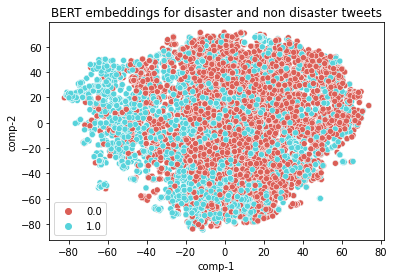

In [17]:
X = BERT_model.predict(train_df['preprocessed_text'].values)
X_embedded = TSNE(n_components=2,random_state=random_state).fit_transform(X)

y=train_df['target'].values

tsne_df = pd.DataFrame()
tsne_df["y"] = y
tsne_df["comp-1"] = X_embedded[:,0]
tsne_df["comp-2"] = X_embedded[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=tsne_df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=tsne_df).set(title="BERT embeddings for disaster and non disaster tweets") 

The plot before fine-tuning shows that the classes are difficult to separate. Even in the locations that are dominated by a certain class, there are a lot of data from the opposing class. Thus, making the task tricky for any model. Actually, random forest and Support Vector Machine (SVM) were tried using BERT representation before fine-tuning. The best result was for SVM around 79% while a fine-tuned model reached around 81.4%.

<b>Fine-Tune The BERT Model</b>

In [18]:
model=fine_tune_model(rate=0.2)

model.summary()

history=model.fit([train_df['preprocessed_text'].values,
          train_df['keyword_mean'].values],
          train_df['target'].values,
          batch_size=64,
          epochs=30)


Model: "Pre-train_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Text_Input (InputLayer)        [(None,)]            0           []                               
                                                                                                  
 BERT_Model (Functional)        (None, 128)          4385921     ['Text_Input[0][0]']             
                                                                                                  
 Keyword_Stats (InputLayer)     [(None, 1)]          0           []                               
                                                                                                  
 Concat_BERT_keywordStats (Conc  (None, 129)         0           ['BERT_Model[0][0]',             
 atenate)                                                         'Keyword_Stats[0][

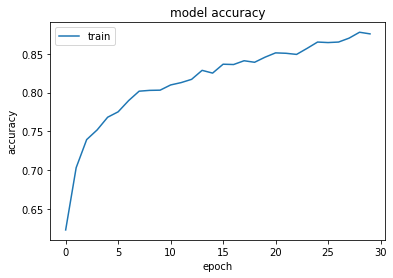

In [19]:
plt.plot(history.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

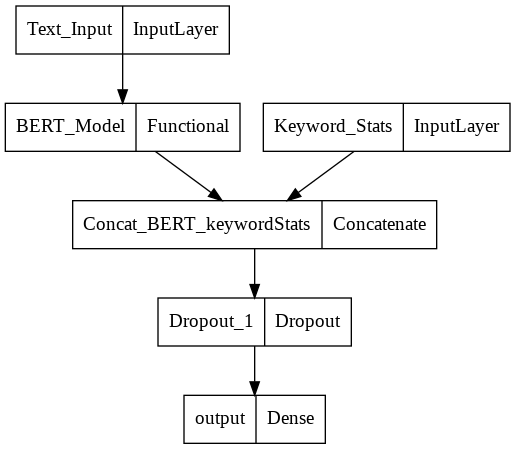

In [20]:
#@title plot_model
plot_model(model, to_file='multiple_inputs.png')

NOTE: the perforance of the model is of little importance since we only aim to fine-tune it to learn a good representation of the data to be used for other models.

<b>TSNE Plot After Fine-Tuning</b>

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


[Text(0.5, 1.0, 'BERT embeddings for disaster and non disaster tweets after fine tuning')]

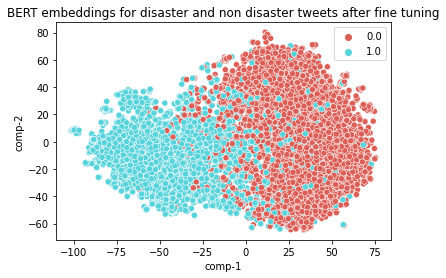

In [21]:
X = BERT_model.predict(train_df['preprocessed_text'].values)
X_embedded = TSNE(n_components=2,random_state=random_state).fit_transform(X)

y=train_df['target'].values

tsne_df = pd.DataFrame()
tsne_df["y"] = y
tsne_df["comp-1"] = X_embedded[:,0]
tsne_df["comp-2"] = X_embedded[:,1]

sns.scatterplot(x="comp-1", y="comp-2", hue=tsne_df.y.tolist(),
                palette=sns.color_palette("hls", 2),
                data=tsne_df).set(title="BERT embeddings for disaster and non disaster tweets after fine tuning") 

The TSNE plot after fine-tuning shows that the classes are now easier to separate. Hence, the BERT model learned a better representation of the classes in the data. Thus, making the prediction task easier for models.

<h4><b>4-Teting The Models</b></h4>

In this part different models are tested using K-Fold cross validation with K given at the beginning as 5. Note the BERT model parameters are freezed. Only the new added layers are trained.

In [ ]:
compile_dic={'optimizer':keras.optimizers.Adam(1e-5,clipvalue=2),
             'loss':keras.losses.binary_crossentropy,
             'metrics':['accuracy']}
batch_size=64
epochs=30
callbacks=[EarlyStopping(monitor='val_accuracy',min_delta=0.02,patience=3,mode='max')]
model1_results,model1_df=valuate_model(train_df,
                                       fine_tune_model,
                                       target_column='target',
                                       use_keyword=True,
                                       compile_dic=compile_dic,
                                       batch_size=batch_size,
                                       callbacks=callbacks,
                                       epochs=epochs)

This model gave a score above 81% on the competition with 30 epochs using the whole training set. Yet we can see that the tests using 15 epochs after finetuning the BERT_model did give good results on some validation sets and bad results on another sets. Thus, either a lot of outliers are present in the validation sets that the model did badly or there are 2 different distributions in the test set.<br/>
The data in these sets should be checked.

In [ ]:
#@title
kfold=StratifiedKFold(n_splits=n_splits,shuffle=True,random_state=random_state)

wanted_indexes=[]
i=1
#iterate through the folds
for train_index,val_index in kfold.split(train_df,train_df['target']):
  if (i==5) or (i==4):
    wanted_indexes+=val_index.tolist()
  
  i+=1

train_df.iloc[wanted_indexes].to_csv('outlier.csv')

<b>Model 1</b>

In [ ]:
def model1():
  rate=0.2

  text_inputs=keras.layers.Input(shape=(),dtype=tf.string,name='Text_Input')
  keyword_inputs=keras.layers.Input(shape=(1,),name='Keyword_Stats')

  # preprocessed_text=preprocessor(text_inputs)
  # outputs=encoder(preprocessed_text)

  BERT_output=BERT_model(text_inputs)

  x=keras.layers.Dropout(rate=rate,name='Dropout_on_BERT_1')(BERT_output)#outputs['pooled_output'])

  #x=keras.layers.Conv1D(30,3)(tf.expand_dims(x,-1))

  #x=keras.layers.Flatten()(x)

  x=keras.layers.Concatenate(name='Concat_BERT_keywordStats_1')([x,keyword_inputs])

  x=keras.layers.Dense(20,activation='relu',name='Dense_layer_1')(x)
  x=keras.layers.Dropout(rate=rate,name='Dropout_1_1')(x)

  y=keras.layers.Dense(1,activation='sigmoid',name='output_1',kernel_regularizer=keras.regularizers.L2())(x)

  model=keras.Model([text_inputs,keyword_inputs],y,name='Model_1')

  #model.compile()
  
  return model

In [ ]:
compile_dic={'optimizer':keras.optimizers.Adam(1e-5,clipvalue=2),
             'loss':keras.losses.binary_crossentropy,
             'metrics':['accuracy']}
batch_size=64
epochs=25
callbacks=[EarlyStopping(monitor='val_accuracy',min_delta=0.02,patience=3,mode='max')]
model1_results,model1_df=valuate_model(train_df,
                                       model1,
                                       target_column='target',
                                       use_keyword=True,
                                       compile_dic=compile_dic,
                                       batch_size=batch_size,
                                       epochs=epochs,
                                       callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Model: "Model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Text_Input (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
BERT_Model (Functional)         (None, 128)          4385921     Text_Input[0][0]                 
__________________________________________________________________________________________________
Dropout_on_BERT_1 (Dropout)     (None, 128)          0           BERT_Model[1][0]                 
__________________________________________________________________________________________________
Keyword_Stats (InputLayer)      [(None, 1)]          0                                            
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


Index(['Unnamed: 0', 'id', 'keyword', 'location', 'text', 'target',
       'trainable', 'preprocessed_text', 'keyword_mean', 'prediction'],
      dtype='object')
<bound method NDFrame.head of       Unnamed: 0     id  ... keyword_mean prediction
0              0      1  ...     0.688525        NaN
1              1      4  ...     0.688525        NaN
2              2      5  ...     0.688525        NaN
3              3      6  ...     0.688525   0.876164
4              4      7  ...     0.688525        NaN
...          ...    ...  ...          ...        ...
7608        7608  10869  ...     0.688525        NaN
7609        7609  10870  ...     0.688525        NaN
7610        7610  10871  ...     0.688525        NaN
7611        7611  10872  ...     0.688525        NaN
7612        7612  10873  ...     0.688525        NaN

[7613 rows x 10 columns]>
1th run:
accuracy: 0.8869485294117647
precision:0.8709677419354839
recall:0.8653846153846154

Epoch 1/25
102/102 [==============================]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


Index(['Unnamed: 0', 'id', 'keyword', 'location', 'text', 'target',
       'trainable', 'preprocessed_text', 'keyword_mean', 'prediction'],
      dtype='object')
<bound method NDFrame.head of       Unnamed: 0     id  ... keyword_mean prediction
0              0      1  ...     0.688525        NaN
1              1      4  ...     0.688525   0.730311
2              2      5  ...     0.688525        NaN
3              3      6  ...     0.688525   0.876164
4              4      7  ...     0.688525   0.581156
...          ...    ...  ...          ...        ...
7608        7608  10869  ...     0.688525        NaN
7609        7609  10870  ...     0.688525        NaN
7610        7610  10871  ...     0.688525   0.832752
7611        7611  10872  ...     0.688525        NaN
7612        7612  10873  ...     0.688525        NaN

[7613 rows x 10 columns]>
2th run:
accuracy: 0.859375
precision:0.890818858560794
recall:0.7670940170940171

Epoch 1/25
102/102 [==============================] - 36s 338m

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


Index(['Unnamed: 0', 'id', 'keyword', 'location', 'text', 'target',
       'trainable', 'preprocessed_text', 'keyword_mean', 'prediction'],
      dtype='object')
<bound method NDFrame.head of       Unnamed: 0     id  ... keyword_mean prediction
0              0      1  ...     0.688525        NaN
1              1      4  ...     0.688525   0.730311
2              2      5  ...     0.688525        NaN
3              3      6  ...     0.688525   0.876164
4              4      7  ...     0.688525   0.581156
...          ...    ...  ...          ...        ...
7608        7608  10869  ...     0.688525        NaN
7609        7609  10870  ...     0.688525   0.733092
7610        7610  10871  ...     0.688525   0.832752
7611        7611  10872  ...     0.688525        NaN
7612        7612  10873  ...     0.688525   0.752123

[7613 rows x 10 columns]>
3th run:
accuracy: 0.8814338235294118
precision:0.8626609442060086
recall:0.860813704496788

Epoch 1/25
102/102 [==============================] 

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


Index(['Unnamed: 0', 'id', 'keyword', 'location', 'text', 'target',
       'trainable', 'preprocessed_text', 'keyword_mean', 'prediction'],
      dtype='object')
<bound method NDFrame.head of       Unnamed: 0     id  ... keyword_mean prediction
0              0      1  ...     0.688525   0.437023
1              1      4  ...     0.688525   0.730311
2              2      5  ...     0.688525        NaN
3              3      6  ...     0.688525   0.876164
4              4      7  ...     0.688525   0.581156
...          ...    ...  ...          ...        ...
7608        7608  10869  ...     0.688525        NaN
7609        7609  10870  ...     0.688525   0.733092
7610        7610  10871  ...     0.688525   0.832752
7611        7611  10872  ...     0.688525        NaN
7612        7612  10873  ...     0.688525   0.752123

[7613 rows x 10 columns]>
4th run:
accuracy: 0.8805147058823529
precision:0.9079903147699758
recall:0.8029978586723768

Epoch 1/25
102/102 [==============================]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


Index(['Unnamed: 0', 'id', 'keyword', 'location', 'text', 'target',
       'trainable', 'preprocessed_text', 'keyword_mean', 'prediction'],
      dtype='object')
<bound method NDFrame.head of       Unnamed: 0     id  ... keyword_mean prediction
0              0      1  ...     0.688525   0.437023
1              1      4  ...     0.688525   0.730311
2              2      5  ...     0.688525        NaN
3              3      6  ...     0.688525   0.876164
4              4      7  ...     0.688525   0.581156
...          ...    ...  ...          ...        ...
7608        7608  10869  ...     0.688525        NaN
7609        7609  10870  ...     0.688525   0.733092
7610        7610  10871  ...     0.688525   0.832752
7611        7611  10872  ...     0.688525        NaN
7612        7612  10873  ...     0.688525   0.752123

[7613 rows x 10 columns]>
5th run:
accuracy: 0.8776448942042319
precision:0.8583690987124464
recall:0.8565310492505354

Epoch 1/25
102/102 [==============================]

Model 1 actually got 80.171% score on the test set.

In [ ]:
test_df['preprocessed_text']=test_df['preprocessed_text'].fillna('great')
test_df['predictions']=(model.predict([test_df['preprocessed_text'].values,test_df['keyword_mean'].values])>0.5).astype(int)
test_df[['id','predictions']].set_index('id').rename(columns={'predictions':'target'}).to_csv('model1_submission.csv')

<b>Model 2</b>

In [ ]:
def model2():
  rate=0.4

  text_inputs=keras.layers.Input(shape=(),dtype=tf.string,name='Text_Input')
  keyword_inputs=keras.layers.Input(shape=(1,),name='Keyword_Stats')

  # preprocessed_text=preprocessor(text_inputs)
  # outputs=encoder(preprocessed_text)

  BERT_output=BERT_model(text_inputs)

  x=keras.layers.Dropout(rate=rate,name='Dropout_on_BERT_2')(BERT_output)#outputs['pooled_output'])

  dropout_keyword=keras.layers.Dropout(rate=0.1,name='Dropout_on_keyword')(keyword_inputs)#outputs['pooled_output'])
  
  #x=keras.layers.Conv1D(30,3)(tf.expand_dims(x,-1))

  #x=keras.layers.Flatten()(x)
  
  #x=keras.layers.Concatenate(name='Concat_BERT_keywordStats_2')([x,keyword_inputs])
  x=keras.layers.Concatenate(name='Concat_BERT_keywordStats_2')([x,dropout_keyword])

  x=tf.expand_dims(x,axis=-1)
  x=keras.layers.Conv1D(100,5,activation='relu',name='Conv_layer_1')(x)
  #x=keras.layers.Flatten()(x)
  x=keras.layers.GlobalMaxPooling1D()(x)
  x=keras.layers.Dropout(rate=rate,name='Dropout_1_2')(x)

  x=keras.layers.Dense(20,activation='relu',name='hidden_layer_1')(x)

  y=keras.layers.Dense(1,activation='sigmoid',name='output_2',kernel_regularizer=keras.regularizers.L2())(x)

  model=keras.Model([text_inputs,keyword_inputs],y,name='Model_2')

  #model.compile()
  
  return model

In [ ]:
compile_dic={'optimizer':keras.optimizers.Adam(1e-3,clipvalue=2),
             'loss':keras.losses.binary_crossentropy,
             'metrics':['accuracy']}
batch_size=64
epochs=25
callbacks=[EarlyStopping(monitor='val_accuracy',min_delta=0.002,patience=3,mode='max',restore_best_weights=True)]
model2_results,model2_df=valuate_model(train_df,
                                       model2,
                                       target_column='target',
                                       use_keyword=True,
                                       compile_dic=compile_dic,
                                       batch_size=batch_size,
                                       epochs=epochs,
                                       callbacks=callbacks)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


Model: "Model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Text_Input (InputLayer)         [(None,)]            0                                            
__________________________________________________________________________________________________
BERT_Model (Functional)         (None, 128)          4385921     Text_Input[0][0]                 
__________________________________________________________________________________________________
Dropout_on_BERT_2 (Dropout)     (None, 128)          0           BERT_Model[4][0]                 
__________________________________________________________________________________________________
Keyword_Stats (InputLayer)      [(None, 1)]          0                                            
____________________________________________________________________________________________

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


Index(['Unnamed: 0', 'id', 'keyword', 'location', 'text', 'target',
       'trainable', 'preprocessed_text', 'keyword_mean', 'predictions_prob',
       'predictions', 'prediction'],
      dtype='object')
<bound method NDFrame.head of       Unnamed: 0     id keyword  ... predictions_prob predictions  prediction
0              0      1     unk  ...         0.716353           1         NaN
1              1      4     unk  ...         0.850362           1         NaN
2              2      5     unk  ...         0.886733           1         NaN
3              3      6     unk  ...         0.902150           1    0.837067
4              4      7     unk  ...         0.743479           1         NaN
...          ...    ...     ...  ...              ...         ...         ...
7608        7608  10869     unk  ...         0.862045           1         NaN
7609        7609  10870     unk  ...         0.856212           1         NaN
7610        7610  10871     unk  ...         0.874403           

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


Index(['Unnamed: 0', 'id', 'keyword', 'location', 'text', 'target',
       'trainable', 'preprocessed_text', 'keyword_mean', 'predictions_prob',
       'predictions', 'prediction'],
      dtype='object')
<bound method NDFrame.head of       Unnamed: 0     id keyword  ... predictions_prob predictions  prediction
0              0      1     unk  ...         0.716353           1         NaN
1              1      4     unk  ...         0.850362           1    0.728285
2              2      5     unk  ...         0.886733           1         NaN
3              3      6     unk  ...         0.902150           1    0.837067
4              4      7     unk  ...         0.743479           1    0.680939
...          ...    ...     ...  ...              ...         ...         ...
7608        7608  10869     unk  ...         0.862045           1         NaN
7609        7609  10870     unk  ...         0.856212           1         NaN
7610        7610  10871     unk  ...         0.874403           

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


Index(['Unnamed: 0', 'id', 'keyword', 'location', 'text', 'target',
       'trainable', 'preprocessed_text', 'keyword_mean', 'predictions_prob',
       'predictions', 'prediction'],
      dtype='object')
<bound method NDFrame.head of       Unnamed: 0     id keyword  ... predictions_prob predictions  prediction
0              0      1     unk  ...         0.716353           1         NaN
1              1      4     unk  ...         0.850362           1    0.728285
2              2      5     unk  ...         0.886733           1         NaN
3              3      6     unk  ...         0.902150           1    0.837067
4              4      7     unk  ...         0.743479           1    0.680939
...          ...    ...     ...  ...              ...         ...         ...
7608        7608  10869     unk  ...         0.862045           1         NaN
7609        7609  10870     unk  ...         0.856212           1    0.723357
7610        7610  10871     unk  ...         0.874403           

KeyboardInterrupt: ignored

Model 2 got 80.876% score on the test set

<b>Other Types of Models</b>

Next I will try to use other ML algorithms after fine-tuning the BERT model

<h6> make the BERT_model un-trainable</h6>

In [ ]:
compile_dic={'optimizer':keras.optimizers.Adam(1e-3,clipvalue=2),
             'loss':keras.losses.binary_crossentropy,
             'metrics':['accuracy']}
BERT_model.trainable=False
BERT_model.compile(**compile_dic)

Prepare the data

In [ ]:
text=train_df['preprocessed_text'].values
keyword_mean=train_df['keyword_mean'].values
keyword_mean=keyword_mean.reshape(-1,1)
print('text:\n',text)
print('keyword_mean:\n',keyword_mean)

text_input=BERT_model.predict(text)

model_input=np.concatenate((text_input,keyword_mean.reshape(-1,1)),axis=1)
print('model_input:\n',model_input)

model_output=train_df['target'].values
print('model_output:\n',model_output)

text:
 ['deeds reason earthquake may allah forgive us'
 'forest fire near la ronge sask canada'
 'residents asked shelter place notified officers evacuation shelter place orders expected'
 ... 'm194 0104 utc5km volcano hawaii'
 'police investigating ebike collided car little portugal ebike rider suffered serious nonlife threatening injuries'
 'latest homes razed northern california wildfire abc news']
keyword_mean:
 [[0.68852459]
 [0.68852459]
 [0.68852459]
 ...
 [0.68852459]
 [0.68852459]
 [0.68852459]]
model_input:
 [[-0.99709314 -0.2516757  -0.87389231 ...  0.97664136  0.92027265
   0.68852459]
 [-0.99958247 -0.20163161 -0.48416367 ...  0.59414071  0.4769721
   0.68852459]
 [-0.96113926 -0.36009893 -0.69679314 ...  0.97529924  0.66572058
   0.68852459]
 ...
 [-0.99784732 -0.24096335  0.1465126  ...  0.67826694  0.58655697
   0.68852459]
 [-0.99585718 -0.26980931 -0.44165894 ...  0.71812952  0.7594111
   0.68852459]
 [-0.99889809 -0.30313087 -0.59138656 ...  0.7010079   0.81738949
  

<b>Random Forest</b>

In [ ]:
# forest_classifier=RandomForestClassifier(random_state=random_state,
#                                          n_jobs=-1)
# parameters={
# 'n_estimators':[100,300,500],
# 'criterion':['gini'],
# 'max_depth':[10,20,25],
# 'min_samples_split':[100,200],
# 'min_samples_leaf':[50,100],
# 'min_weight_fraction_leaf':[0.0],
# 'max_leaf_nodes':[20,30]
# }
# clf=GridSearchCV(forest_classifier,parameters,verbose=1,cv=5)

clf=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=20, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=27, verbose=0,
                       warm_start=False)

clf.fit(model_input,model_output)

# best_classifier=clf.best_estimator_
best_classifier=clf

Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 360 out of 360 | elapsed: 41.8min finished


The grid search took more than 40m

In [ ]:
# clf.best_score_

0.9006964606648991

In [ ]:
best_classifier

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=20, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=50, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=-1, oob_score=False, random_state=27, verbose=0,
                       warm_start=False)

In [ ]:
text=test_df['preprocessed_text'].values
keyword_mean=test_df['keyword_mean'].values
keyword_mean=keyword_mean.reshape(-1,1)
print('text:\n',text)
print('keyword_mean:\n',keyword_mean)

text_input=BERT_model.predict(text)

test_input=np.concatenate((text_input,keyword_mean.reshape(-1,1)),axis=1)
print('test_input:\n',model_input)

test_df['target']=best_clasifier.predict(test_input).ravel()
test_df['target']=test_df['target'].astype(int)

test_df[['id','target']].set_index('id').to_csv('submission.csv')

text:
 ['happened terrible car crash'
 'heard earthquake different cities stay safe everyone'
 'forest fire spot pond geese fleeing across street cannot save' ...
 'green line derailment chicago'
 'meg issues hazardous weather outlook hwo'
 'cityofcalgary activated municipal emergency plan yycstorm']
keyword_mean:
 [[0.68852459]
 [0.68852459]
 [0.68852459]
 ...
 [0.68852459]
 [0.68852459]
 [0.68852459]]
test_input:
 [[-0.99709314 -0.2516757  -0.87389231 ...  0.97664136  0.92027265
   0.68852459]
 [-0.99958247 -0.20163161 -0.48416367 ...  0.59414071  0.4769721
   0.68852459]
 [-0.96113926 -0.36009893 -0.69679314 ...  0.97529924  0.66572058
   0.68852459]
 ...
 [-0.99784732 -0.24096335  0.1465126  ...  0.67826694  0.58655697
   0.68852459]
 [-0.99585718 -0.26980931 -0.44165894 ...  0.71812952  0.7594111
   0.68852459]
 [-0.99889809 -0.30313087 -0.59138656 ...  0.7010079   0.81738949
   0.68852459]]


Random Forest got an 80.723% accuracy, slightly less than Model 2.

<b>Support Vector Classifier</b>

Now let us try Support Vector classifier (SVC)

In [ ]:
# svc_classifier=SVC(random_state=random_state)
# parameters={
#     'C':[0.2,0.5,1.0,1.2,1.5],
#     'kernel':['rbf','sigmoid','linear'],
#     'degree':[3],
#     'gamma':['scale','auto'],
# }
# clf=GridSearchCV(svc_classifier,parameters,verbose=1,cv=5)

clf=SVC(C=0.2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=27, shrinking=True, tol=0.001,
    verbose=False)

clf.fit(model_input,model_output)

# best_classifier=clf.best_estimator_
best_classifier=clf

In [ ]:
# clf.best_score_

In [ ]:
best_classifier

SVC(C=0.2, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=27, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
text=test_df['preprocessed_text'].values
keyword_mean=test_df['keyword_mean'].values
keyword_mean=keyword_mean.reshape(-1,1)
print('text:\n',text)
print('keyword_mean:\n',keyword_mean)

text_input=BERT_model.predict(text)

test_input=np.concatenate((text_input,keyword_mean.reshape(-1,1)),axis=1)
print('test_input:\n',model_input)

test_df['target']=best_classifier.predict(test_input).ravel()
test_df['target']=test_df['target'].astype(int)

test_df[['id','target']].set_index('id').to_csv('submission.csv')

text:
 ['happened terrible car crash'
 'heard earthquake different cities stay safe everyone'
 'forest fire spot pond geese fleeing across street cannot save' ...
 'green line derailment chicago'
 'meg issues hazardous weather outlook hwo'
 'cityofcalgary activated municipal emergency plan yycstorm']
keyword_mean:
 [[0.68852459]
 [0.68852459]
 [0.68852459]
 ...
 [0.68852459]
 [0.68852459]
 [0.68852459]]
test_input:
 [[-0.99709314 -0.2516757  -0.87389231 ...  0.97664136  0.92027265
   0.68852459]
 [-0.99958247 -0.20163161 -0.48416367 ...  0.59414071  0.4769721
   0.68852459]
 [-0.96113926 -0.36009893 -0.69679314 ...  0.97529924  0.66572058
   0.68852459]
 ...
 [-0.99784732 -0.24096335  0.1465126  ...  0.67826694  0.58655697
   0.68852459]
 [-0.99585718 -0.26980931 -0.44165894 ...  0.71812952  0.7594111
   0.68852459]
 [-0.99889809 -0.30313087 -0.59138656 ...  0.7010079   0.81738949
   0.68852459]]


SVC got a slightly better than random forest with 80.907% accuracy. 

In the end, the best model was the one used to to fine-tune the BERT model with a score of 81.274% accuracy.

<h4><b>5-Generate the Results</b><h4/>


This codes can be used to generate the results for the previous models. The desired model should be trained before running these codes.

In [ ]:
print(test_df[test_df['preprocessed_text'].isnull()])

test_df['preprocessed_text']=test_df['preprocessed_text'].fillna('great')

Empty DataFrame
Columns: [Unnamed: 0, id, keyword, location, text, target, trainable, preprocessed_text, keyword_mean]
Index: []


In [ ]:
#print(model.predict(x=[test_df['preprocessed_text'].values,test_df['keyword_mean'].values]))

test_df['predictions']=(model.predict([test_df['preprocessed_text'].values,test_df['keyword_mean'].values])>0.5).astype(int)

In [ ]:
test_df[['id','predictions']].set_index('id').rename(columns={'predictions':'target'}).to_csv('submission.csv')

<h4><b>5-Save The Model</b><h4/>

In [ ]:
model_version = "001"
model_name = "disaster-tweets-model"
model_path = os.path.join(model_name, model_version)
tf.saved_model.save(model, model_path)
shutil.make_archive(model_name, 'zip', model_name)

INFO:tensorflow:Assets written to: disaster-tweets-model/001/assets


INFO:tensorflow:Assets written to: disaster-tweets-model/001/assets


In [ ]:
!saved_model_cli show --dir $model_path --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['Keyword_Stats'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: serving_default_Keyword_Stats:0
    inputs['Text_Input'] tensor_info:
        dtype: DT_STRING
        shape: (-1)
        name: serving_default_Text_Input:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: StatefulPartitionedCall_2:0
  Method name is: tensorflow/serving/predict
T

<h1><b>Conclusion<b/><h1/>

BERT model was fine-tuned on the training data. It used the text preprocessor that comes with the model. aditional information was used from the keyword statistics.<br/>
Many models were tested. BERT with an additional single output neuron, BERT with 1 hidden layer and 1 output layer, BERT with 1 hidden layer using convolution and 1 output layer, and lastly random forest and support vector machines were used on the BERT generated features and the keyword stats.<br/>
The best model was the BERT with 1 output layer. This model achieved 81.274% accuracy.